# Clusterless Decoding Implementation

### Simulating the position data

We first simulate the position of the mouse running back and fourth along a linear track with the following transition probability

$p(x_k | x_{k-1}) \sim N(\alpha x_{k-1}, \sigma)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
sns.set_context('notebook')

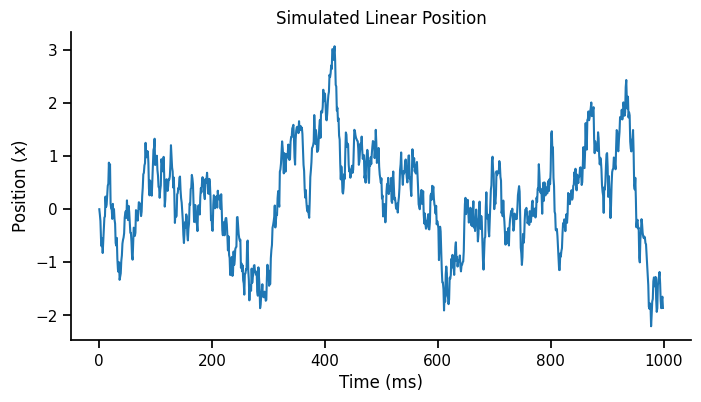

In [53]:
alpha = 0.98
sigma = 0.05
n_timesteps = 1000
x = np.zeros(n_timesteps)
for k in range(n_timesteps - 1):
    x[k + 1] = np.random.normal(alpha * x[k], np.sqrt(sigma))

plt.figure(figsize=(8, 4))
sns.lineplot(x)
plt.xlabel('Time (ms)')
plt.ylabel('Position $(x)$')
plt.title('Simulated Linear Position')
sns.despine()
plt.show()


### Defining functions to describe spiking activity and associated marks

We now define our simulation joint mark intensity $\lambda(t, \vec{m})$ of two hippocampal place cells using a bivariate Gaussian mixture function as in Eq. 8




In [54]:
def joint_mark_intensity(x, m, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The joint mark intensity function for our simulation model.
    '''
    
    jmi = 0
    for c in [0,1]:
        jmi += np.exp((a[c] - ((x - mu_x[c])**2) / (2*sigma_x[c]**2))  -  ((m - mu_m[c])**2) / (2*sigma_m[c]**2))

    return jmi



We integrate the joint mark intensity over the mark space $M$ to get our ground process rate $ \Lambda(t) = \int_M \lambda(t, \vec{m})dm$ 

In [55]:
def ground_process_rate(x, mu_x, sigma_x, a):
    '''
    The ground process for our simulation model, which is the integral of the joint mark intensity function with respect to m.
    '''

    rate = 0
    for c in [0,1]:
        rate += np.exp(a[c]) * np.exp(-((x - mu_x[c])**2) / (2*sigma_x[c]**2))
    
    return rate
    


We also need to define a function to simulate the inhomogeneous Poisson process using the ground process rate. We use the thinning algorithm below.

In [56]:

def HomogeneousPoisson(rate, t_old):
    """
    Generate a new event time for a homogeneous Poisson process.
    """
    u = np.random.rand()
    t_new = -np.log(u) / rate + t_old
    return t_new

def InHomoPoisson(rate, t_old):
    """
    Simulate an inhomogeneous Poisson process using the thinning algorithm.
    """
    gmax = np.max(rate)  # Upper bound for thinning

    while True:
        # Generate a candidate event time from the homogeneous Poisson process
        t = HomogeneousPoisson(gmax, t_old)

        # Check if time exceeds rate length (end of simulation)
        if t >= len(rate):
            return None  # Signal end of process

        # Interpolate the rate at the candidate time
        rate_value = np.interp(t, np.arange(len(rate)), rate)

        # Thinning: Accept or reject the event
        u = np.random.rand()
        if u * gmax < rate_value:
            return t  # Event accepted
        else:
            t_old = t  # Update the last time and continue
            


Finally, we can define the pdf from which the marks associated with the spike train which are sampled $f(\vec{m}|t) = \frac{\lambda(t, \vec{m})}{\Lambda(t|H_t)}$

In [57]:
def marks_pdf(m, x, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The marks pdf for our simulation model which is the joint mark intensity divided by the ground process rate.
    '''
    
    return joint_mark_intensity(x, m, mu_x, mu_m, sigma_x, sigma_m, a) / ground_process_rate(x, mu_x, sigma_x, a)

### Simulating the neural data

Now that our functions are defined, the first thing to do is simulate our ground process rate $ \Lambda(t)$

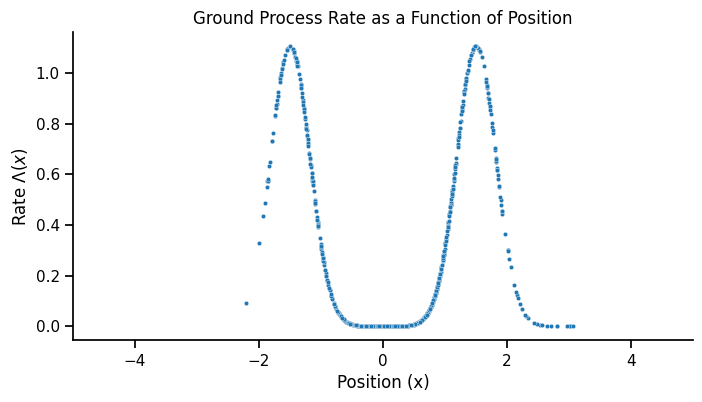

In [58]:
# Defining the parameters of the simulation model
mu_x = [-1.5, 1.5]
sigma_x = [np.sqrt(0.1), np.sqrt(0.1)]
a = [0.1, 0.1]
mu_m = [10, 13]
sigma_m = [np.sqrt(2),np.sqrt(2)]

# simulating the ground process rate
rate = np.zeros(n_timesteps)
for k in range(n_timesteps):
    rate[k] = ground_process_rate(x[k], mu_x, sigma_x, a)


# Plotting the ground process rate as a function of position
plt.figure(figsize=(8, 4))
sns.scatterplot(x = x, y = rate, s = 10)
plt.xlabel("Position (x)")
plt.ylabel("Rate $\\Lambda(x)$")
plt.title("Ground Process Rate as a Function of Position")
plt.xlim(-5, 5)
sns.despine()
plt.show()

Now we can use the ground process rate to simulate the spike times using an inhomogeneous Poisson process.

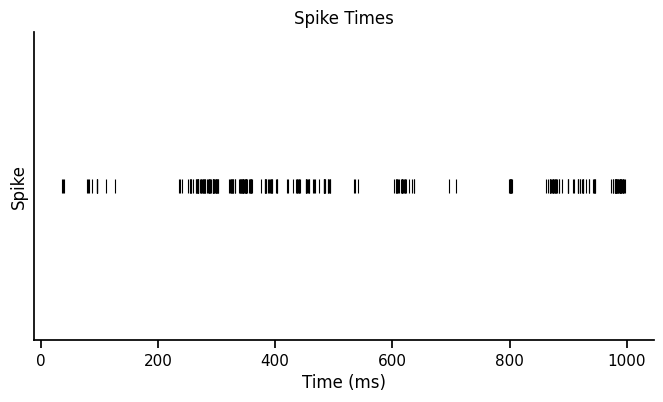

In [59]:
spike_times = []
t = 0
while t < n_timesteps:
    t = InHomoPoisson(rate, t)
    if t is not None:
        spike_times.append(t)
    else:
        break


# plotting the spike times
plt.figure(figsize = (8, 4))
sns.scatterplot(x=spike_times, y=np.ones(len(spike_times)), marker='|', s=100, color='k')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.yticks([])
plt.title('Spike Times')
sns.despine()
plt.show()



We can use these spike times to simulate our marks by sampling from $f(\vec{m}|t)$. We will use the method of rejection sampling.

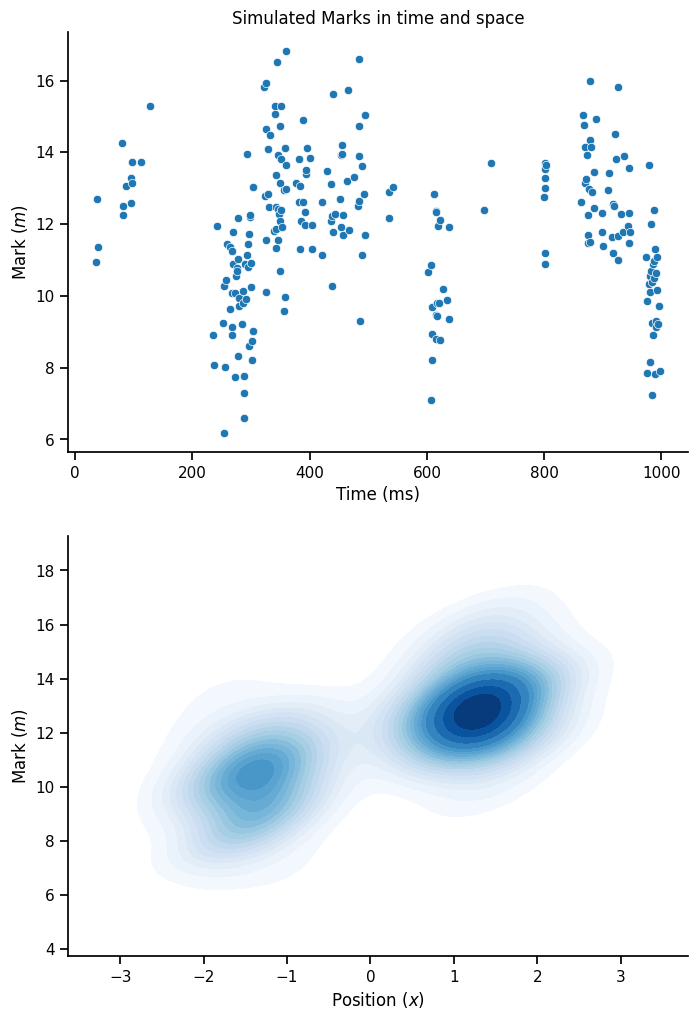

In [60]:
# Rejection sampling
def sample_from_marks_pdf(pdf, m_min, m_max, x, mu_x, mu_m, sigma_x, sigma_m, a, n_samples):
    samples = []
    while len(samples) < n_samples:
        m = np.random.uniform(m_min, m_max)  # Sample m uniformly in range
        y = np.random.uniform(0, 1)         # Use 1 as an upper bound for PDF
        if y < pdf(m, x, mu_x, mu_m, sigma_x, sigma_m, a):
            samples.append(m)
    return np.array(samples)


# simulating the marks
marks = []
x_spikes = x[np.array(spike_times, dtype = int)]
for t in range(len(spike_times)):
    current_x = x_spikes[t]
    marks.append(sample_from_marks_pdf(marks_pdf, 0, 20, current_x, mu_x, mu_m, sigma_x, sigma_m, a, 1)[0])


# plotting the marks as a function of time
fig, axs = plt.subplots(2,1, figsize=(8, 12))
sns.scatterplot(x = spike_times, y = marks, ax=axs[0])
sns.kdeplot(x = x_spikes, y = marks, cmap='Blues', fill = True, levels = 20, ax=axs[1])
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Mark $(m)$')
axs[0].set_title('Simulated Marks in time and space')
axs[1].set_xlabel('Position $(x)$')
axs[1].set_ylabel('Mark $(m)$')


sns.despine()
plt.show()





    

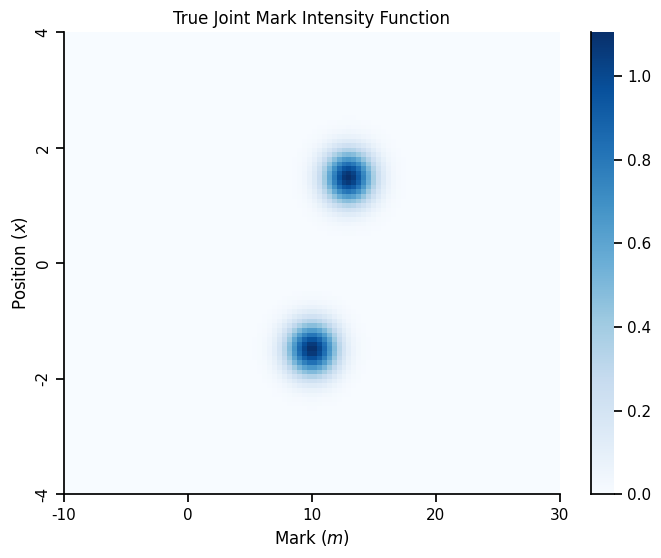

In [61]:
# plotting the true joint mark intensity function used to simulate the data
x_range = np.linspace(-4, 4, 100)
m_range = np.linspace(-10, 30, 100)
X, M = np.meshgrid(x_range, m_range)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = joint_mark_intensity(X[i, j], M[i, j], mu_x, mu_m, sigma_x, sigma_m, a)

plt.figure(figsize=(8, 6))
sns.heatmap(Z.T, cmap='Blues', xticklabels=10, yticklabels=10)
plt.ylabel('Position $(x)$')
plt.yticks(np.linspace(0, 100, 5), np.linspace(-4, 4, 5, dtype=int))
plt.xticks(np.linspace(0, 100, 5), np.linspace(-10, 30, 5, dtype=int))
plt.xlabel('Mark $(m)$')
plt.title('True Joint Mark Intensity Function')
plt.gca().invert_yaxis()
sns.despine()
plt.show()



### Decoding the position from the simulated neural data

First we will define functions which will enable us to numerically integrating the chapman-kolmogorov equation as in Eq. 4. That is the integral of the state evolution * prior density over the position space

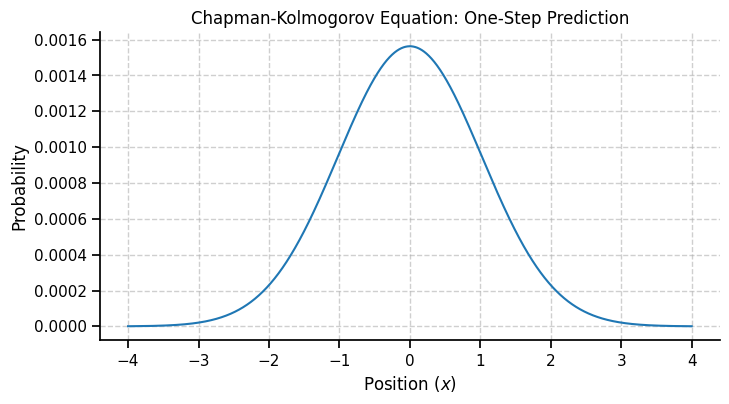

In [62]:
# discretizing the position
x_min, x_max = -4, 4
N = 2000
dx = (x_max - x_min) / N
x_range = np.linspace(x_min, x_max, N)


# Defining the state evolution model
def state_evolution(x_new, x_old, alpha, sigma):
    '''getting the probability of transitioning from x_k_minus_1 to x_k'''
    return  (np.exp(-((x_new - alpha * x_old)**2) / (2 * sigma**2))) / np.sqrt(2 * np.pi * sigma**2)


# Defining the initial prior density of x for the first time step.
def initial_prior_density(x, mu, sigma):
    '''getting the prior density of x. Used for intializing the forward filtering algorithm. Here we use a Gaussian distribution'''
    prior = np.exp(-((x - mu)**2) / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    prior /= np.sum(prior)
    return prior

def chapman_kolmogorov(x_range, alpha, sigma, prior):
    '''Implementing the Chapman-Kolmogorov equation for the state evolution model'''
    x_new, x_old = np.meshgrid(x_range, x_range)
    transition = np.exp(-((x_new - alpha * x_old)**2) / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    probabilities = np.dot(transition, prior) * dx
    probabilities /= np.sum(probabilities)
    return probabilities

# testing the Chapman-Kolmogorov equation
prior = initial_prior_density(x_range, 0,1)
probabilities = chapman_kolmogorov(x_range, alpha, sigma, prior)
plt.figure(figsize=(8, 4))
sns.lineplot(x=x_range, y=probabilities)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Position $(x)$')
plt.ylabel('Probability')
plt.title('Chapman-Kolmogorov Equation: One-Step Prediction')
sns.despine()
plt.show()





Now we define the likelihood or observation distribution as in Eq. 5

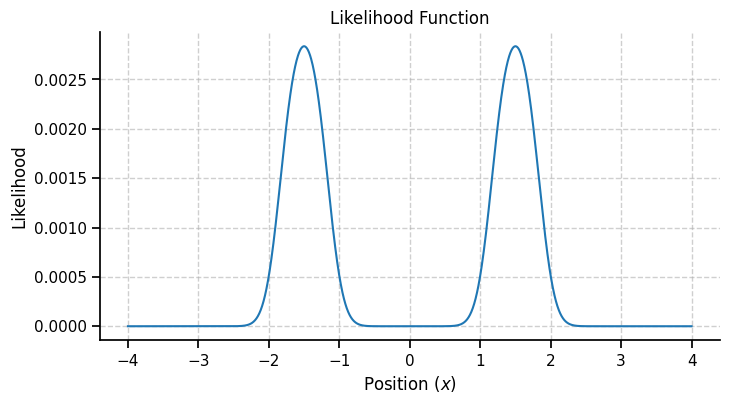

In [63]:
def likelihood(Delta_N_k, Delta_k, x_range, m_k, mu_x, mu_m, sigma_x, sigma_m, a):
    '''Getting the likelihood of the data at time k given the state x_k and mark m_k'''
    # Precompute ground process rate for all x_range
    ground_rate = ground_process_rate(x_range, mu_x, sigma_x, a)
    all_likelihoods = np.zeros(len(x_range))

    if Delta_N_k == 0:
        # Likelihood when no spikes occur
        all_likelihoods = np.exp(-Delta_k * ground_rate)
    else:
        # Likelihood when spikes occur
        for j, x_new in enumerate(x_range):
            # Compute joint mark intensity product
            log_jmi = 0
            for k in range(Delta_N_k):
                log_jmi += np.log(joint_mark_intensity(x_new, m_k[k], mu_x, mu_m, sigma_x, sigma_m, a) * Delta_k)

            # Final likelihood calculation
            all_likelihoods[j] = np.exp(log_jmi) * np.exp(-Delta_k * ground_rate[j])

    # Normalize likelihood
    all_likelihoods /= np.sum(all_likelihoods)
    return all_likelihoods


# testing the likelihood function
Delta_N_k = 2
Delta_k = 1
m_k = [10, 13]
likelihoods = likelihood(Delta_N_k, Delta_k, x_range, m_k, mu_x, mu_m, sigma_x, sigma_m, a)
plt.figure(figsize=(8, 4))
sns.lineplot(x = x_range, y = likelihoods)
plt.xlabel('Position $(x)$')
plt.ylabel('Likelihood')
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Likelihood Function')
sns.despine()
plt.show()


    


Finally, we can put everything together and begin the decoding

In [64]:
# running the forward filtering algorithm
probabilities = np.zeros((n_timesteps, N))
probabilities[0, :] = initial_prior_density(x_range, 0, 1)

for k in tqdm.tqdm(range(n_timesteps - 1), desc='Running Forward Filtering Algorithm'):

    # getting the number of spikes and the marks in the interval [t_{k-1}, t_k]
    Delta_N_k = 0
    current_marks = []
    for i, t in enumerate(spike_times):
        if t >= k and t < k + 1:
            Delta_N_k += 1
            current_marks.append(marks[i])

    probabilities[k + 1, :] = chapman_kolmogorov(x_range, alpha, sigma, probabilities[k, :]) * likelihood(Delta_N_k, 1, x_range, current_marks, mu_x, mu_m, sigma_x, sigma_m, a)

    # normalizing the probabilities to account for denominator normalization term and for numerical stability
    probabilities[k + 1, :] = probabilities[k + 1, :] / np.sum(probabilities[k + 1, :])


Running Forward Filtering Algorithm: 100%|██████████| 999/999 [01:08<00:00, 14.65it/s]


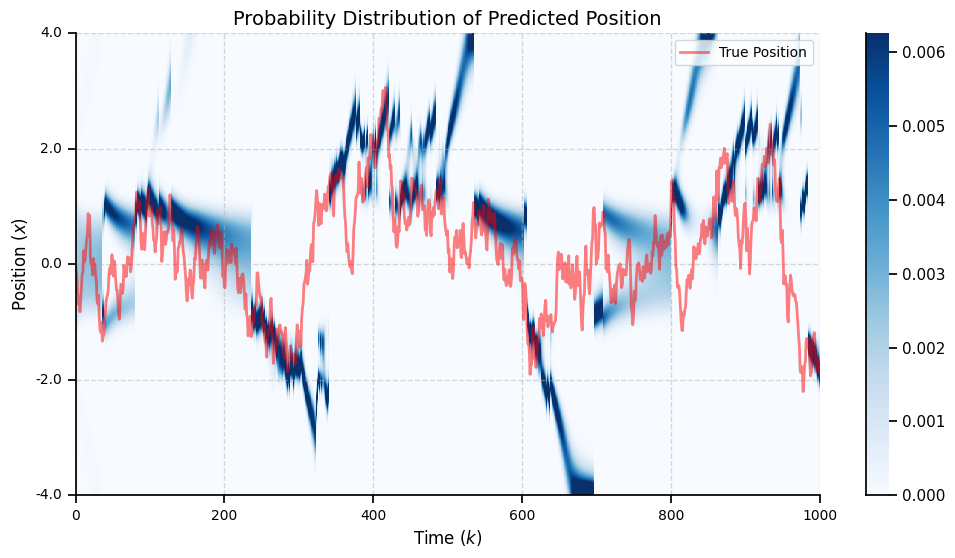

In [66]:
# Find the closest row indices for true positions in the discretized grid
true_position_indices = np.array([np.argmin(np.abs(x_range - pos)) for pos in x])

# Plot the probability distribution of predicted position
plt.figure(figsize=(12, 6))
sns.heatmap(probabilities.T, cmap='Blues', xticklabels=10, yticklabels=10, robust=True)
plt.ylabel('Position $(x)$', fontsize=12)
plt.xlabel('Time $(k)$', fontsize=12)
plt.title('Probability Distribution of Predicted Position', fontsize=14)

# Overlay the true positions
plt.plot(np.arange(len(x)), true_position_indices, color='red', linewidth=2, alpha = 0.5, label='True Position')


# Adjust axis ticks
plt.xticks(np.linspace(0, n_timesteps, 6), np.linspace(0, n_timesteps, 6, dtype=int), fontsize=10, rotation=0)
plt.yticks(np.linspace(0, len(x_range), 5), np.linspace(x_min, x_max, 5, dtype=float), fontsize=10)
plt.gca().invert_yaxis()

# Add legend and grid
plt.legend(loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
sns.despine()
plt.show()


